In [1]:
# Data
import pandas as pd
import numpy as np

# Ploting
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
## sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from feature_engine.encoding import RareLabelEncoder
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

# Functions

## Pipeline functions

In [22]:
class PandasTransformerMixin:
    def set_output(self, transformer):
        self.transformer = transformer
        return self

    def get_output(self):
        if hasattr(self, 'transformer') and self.transformer == "pandas":
            return pd.DataFrame
        else:
            return None

In [23]:
class CategoricalGrouping(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=50):
        self.threshold = threshold
        self.categories = {}
    
    def fit(self, X, y=None):
        object_cols = X.select_dtypes(include='object').columns
        for col in object_cols:
            val_counts = X[col].value_counts()
            self.categories[col] = val_counts[val_counts >= self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        X = X.copy()
        object_cols = X.select_dtypes(include='object').columns
        for col in object_cols:
            if col in self.categories:
                # Replace values below threshold and missing values with "other"
                X[col] = X[col].where(X[col].isin(self.categories[col]), "other")
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


In [24]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping = {}

    def fit(self, X, y):
        self.mapping = {}
        df = pd.concat([X, y], axis=1)
        for col in X.columns:
            target_mean = df.groupby(col)[y.name].mean()
            self.mapping[col] = target_mean
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col, target_mean in self.mapping.items():
            X_encoded[col] = X[col].map(target_mean)
        return X_encoded

In [25]:
class RemoveIdenticalColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_drop_ = np.where(X.nunique() == 1)[0]
        return self

    def transform(self, X):
        return X.drop(columns=X.columns[self.columns_to_drop_])

In [26]:
class RemoveWhitespace(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [59]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.selected_columns = []

    def fit(self, X, y=None):
        self.selected_columns = []
        for col in X.columns:
            corr = abs(X[col].corr(y))
            if corr >= self.threshold:
                self.selected_columns.append(col)
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_columns]

## Other functions

In [42]:
def plot_numerical_variables(data, target_variable):
    numerical_columns = list(data.select_dtypes(include=['float', 'int']).columns)
    numerical_columns.remove(target_variable)
    
    for column in numerical_columns:
        sns.regplot(data=data, x=column, y=target_variable, lowess=True, line_kws={'color': 'red'})
        plt.title(f'{column} vs {target_variable}')
        plt.xlabel(column)
        plt.ylabel(target_variable)
        
        corr_coef = np.corrcoef(data[column], data[target_variable])[0, 1]
        legend_text = f'Correlation: {corr_coef:.2f}'
        plt.legend([legend_text])
        
        plt.show()


In [57]:
def get_low_correlation_variables(data, target_variable, threshold=0.1):
    numerical_columns = data.select_dtypes(include=['float', 'int']).columns
    low_corr_variables = []

    for column in numerical_columns:
        corr = np.abs(data[column].corr(data[target_variable]))
        if corr < threshold:
            low_corr_variables.append(column)

    return low_corr_variables


# Load and split data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [51]:
feature_list = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']

target = 'SalePrice'

In [5]:
X_train = train[feature_list]
y_train = train[target]

X_test = test[feature_list]

In [6]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype in ('int64', 'float64')]

# Data Pipeline

In [50]:
set_config(transform_output = 'pandas')

use_target_encoding = True

if use_target_encoding:
    CategoricalEncoding = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                        RareLabelEncoder(tol=0.05, n_categories = 2), 
                                        TargetEncoder(),
                                        StandardScaler())
else:
    CategoricalEncoding = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                        RareLabelEncoder(tol=0.05, n_categories = 2),
                                        OneHotEncoder(drop='first', sparse_output=False, 
                                                      handle_unknown="ignore"))


num_pipe = make_pipeline(SimpleImputer(), StandardScaler())

num_cat_pipe = ColumnTransformer(
    (
        ("categorical", CategoricalEncoding, cat_cols),
        ("numerical", num_pipe, num_cols),
    ),
    verbose_feature_names_out=False,
    remainder = 'passthrough'
)

treatment_pipe = make_pipeline(num_cat_pipe, RemoveIdenticalColumns())


In [31]:
treatment_pipe.fit(X_train, y_train)

X_train_t = treatment_pipe.transform(X_train)
X_test_t = treatment_pipe.transform(X_test)

c:\Users\Jonas\anaconda3\envs\automl\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Jonas\anaconda3\envs\automl\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Jonas\anaconda3\envs\automl\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Jonas\anaconda3\envs\automl\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable LotShape is less than

# Plots

In [52]:
df_train = X_train_t.copy()
df_train[target] = y_train

c:\Users\Jonas\anaconda3\envs\automl\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


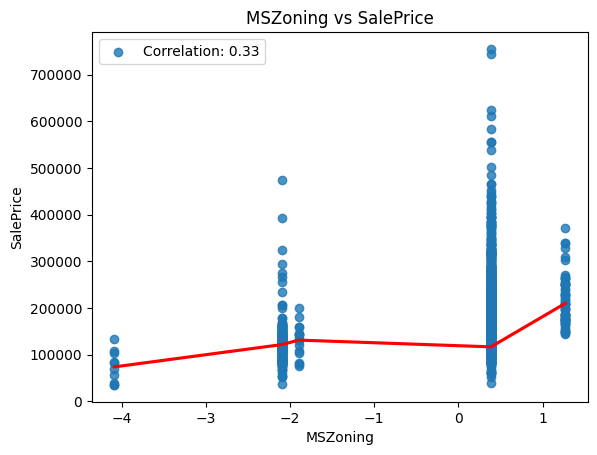

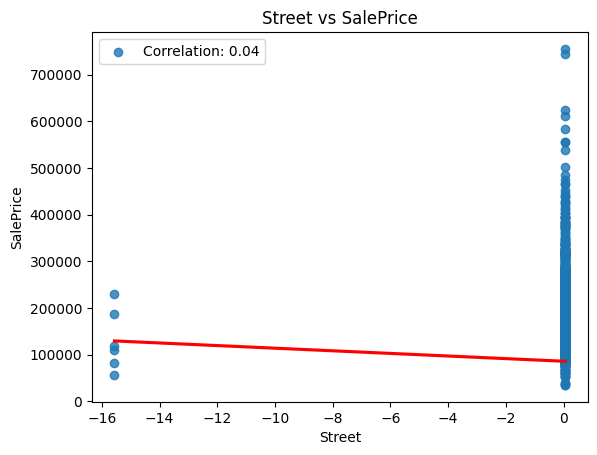

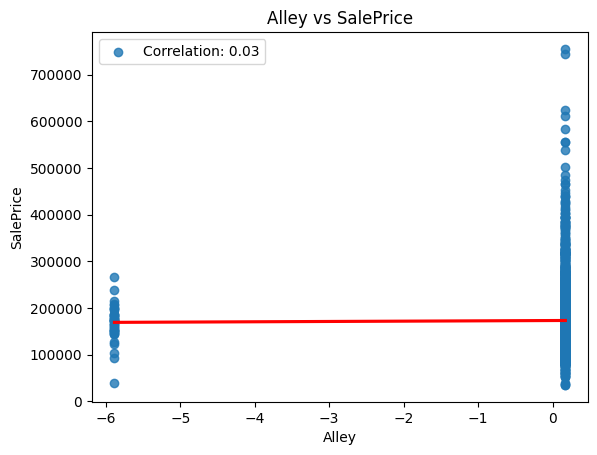

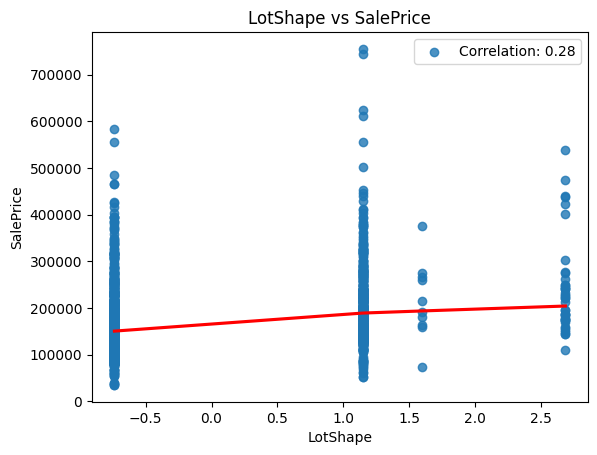

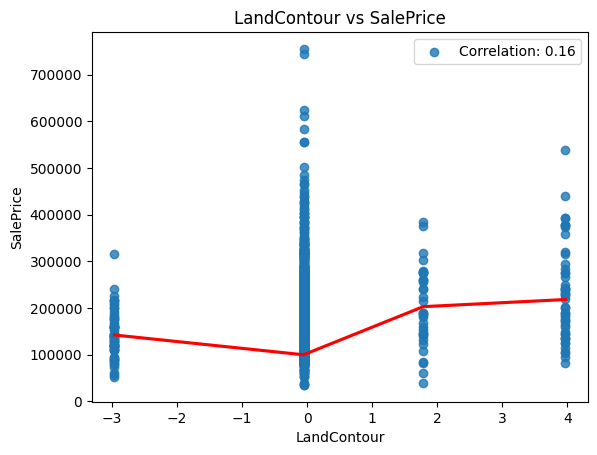

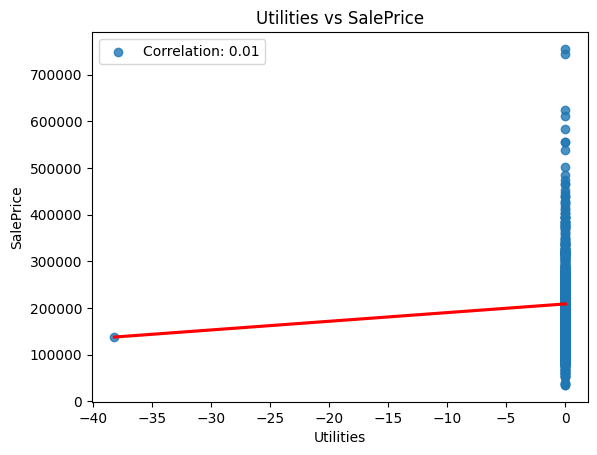

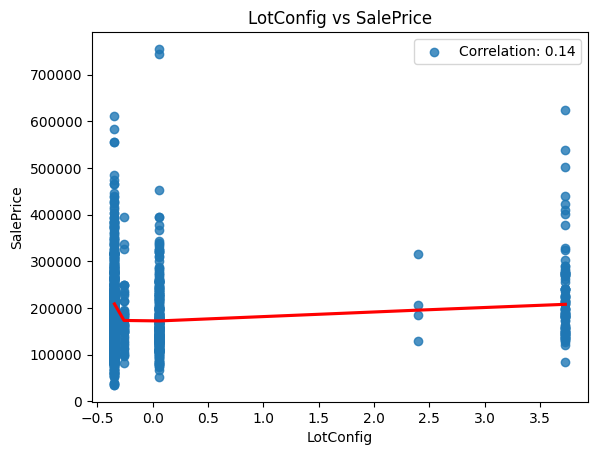

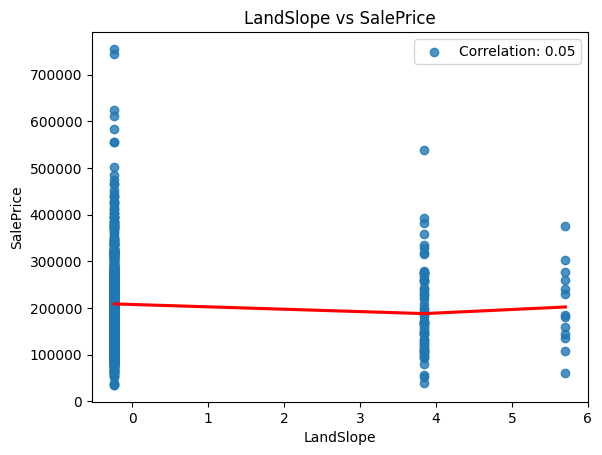

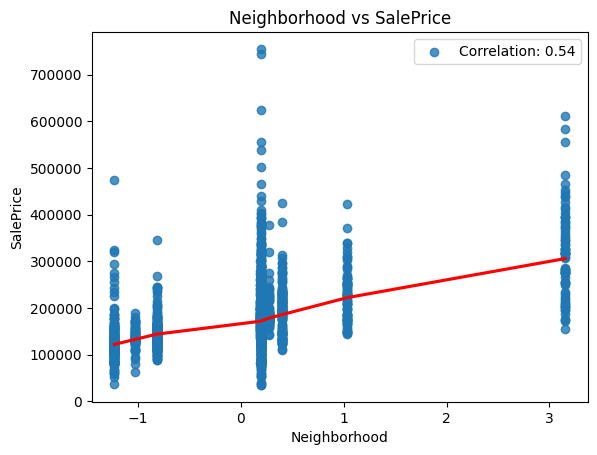

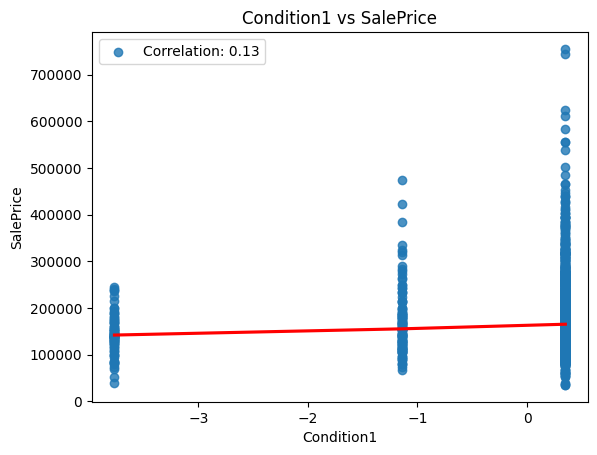

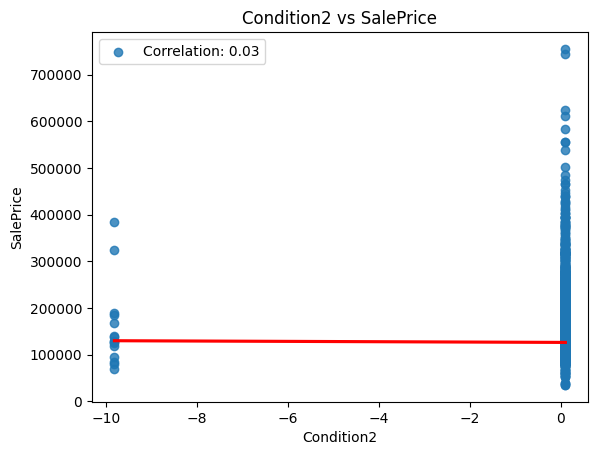

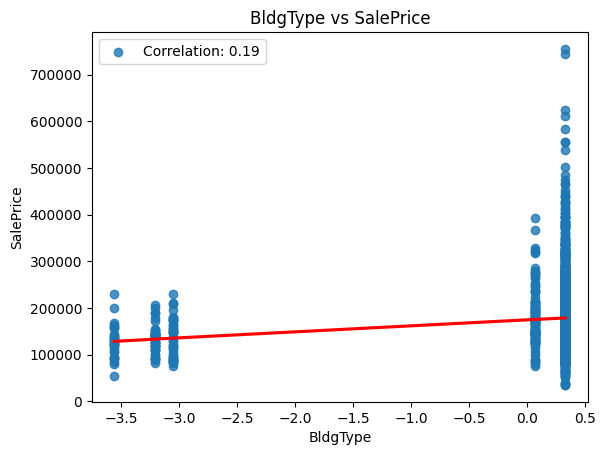

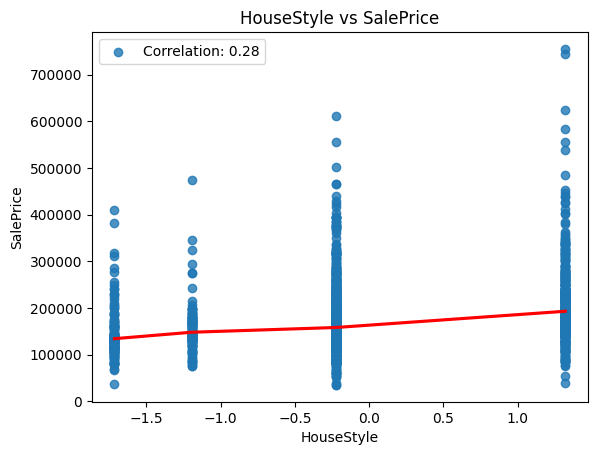

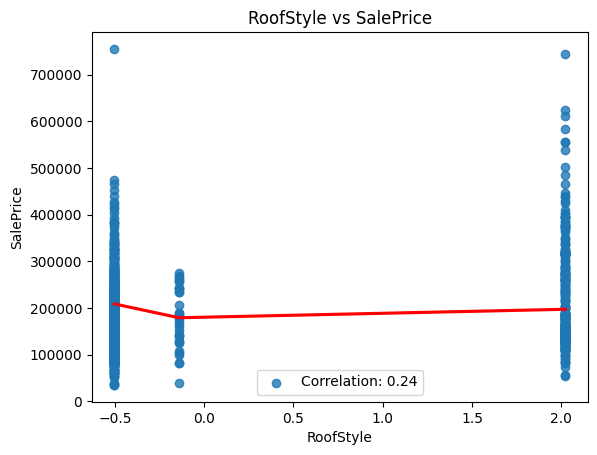

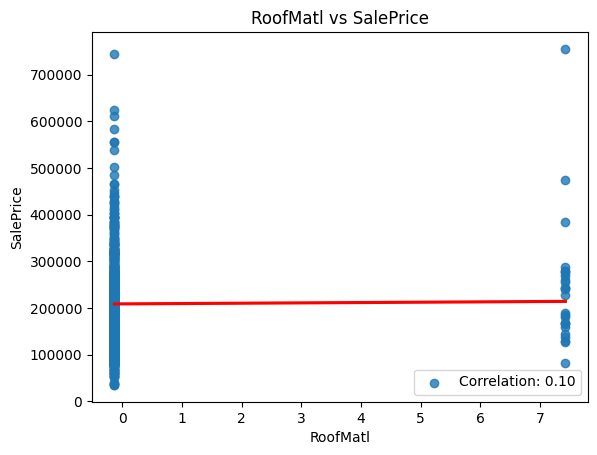

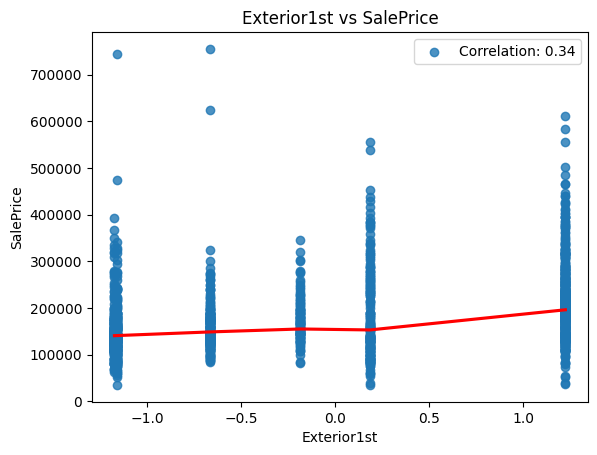

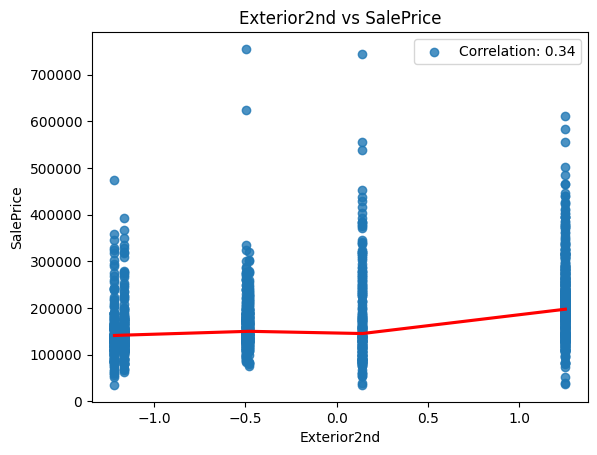

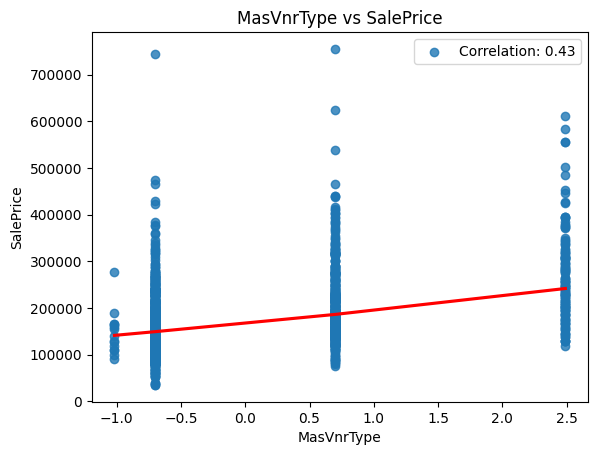

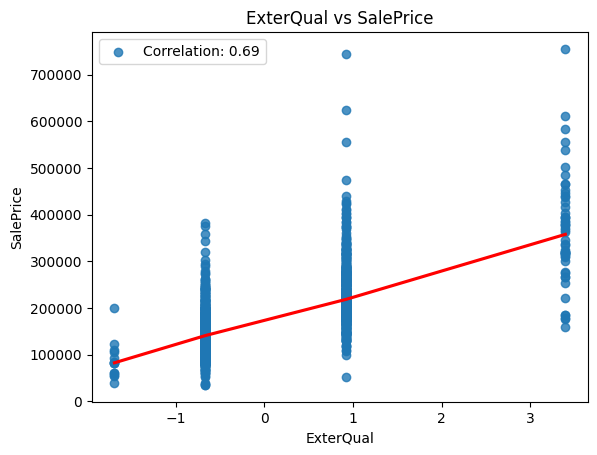

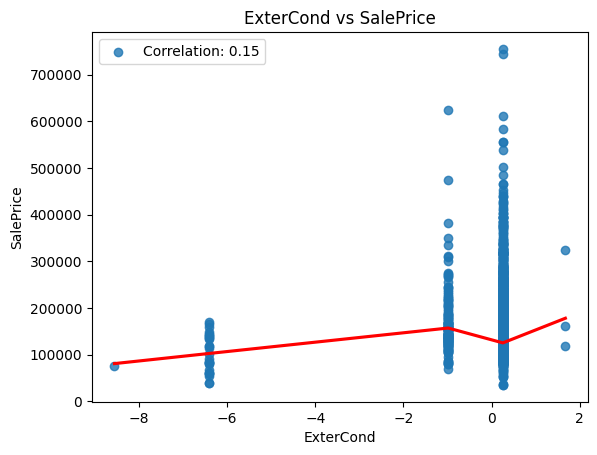

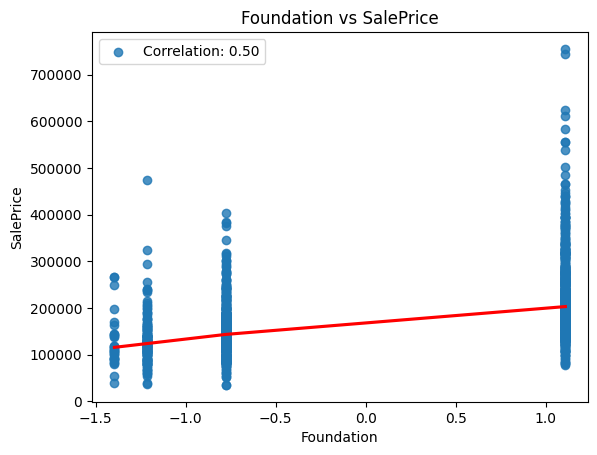

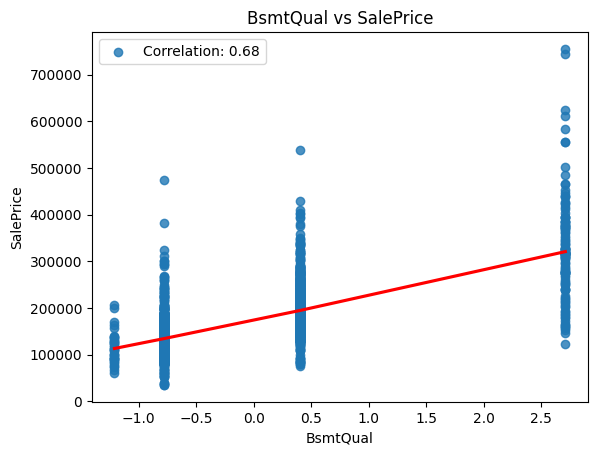

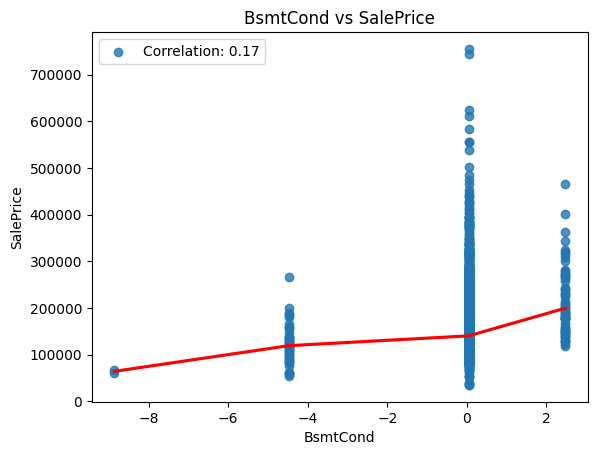

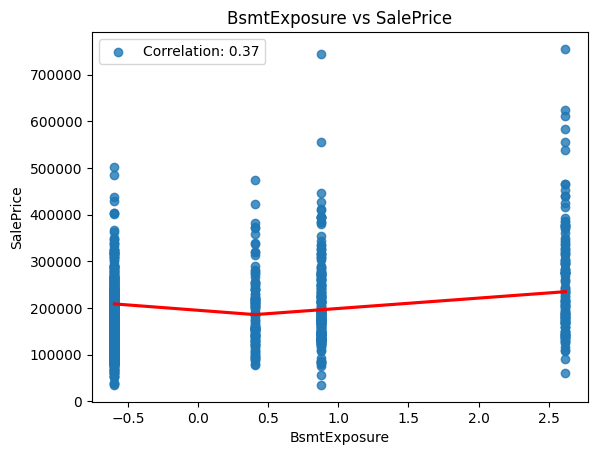

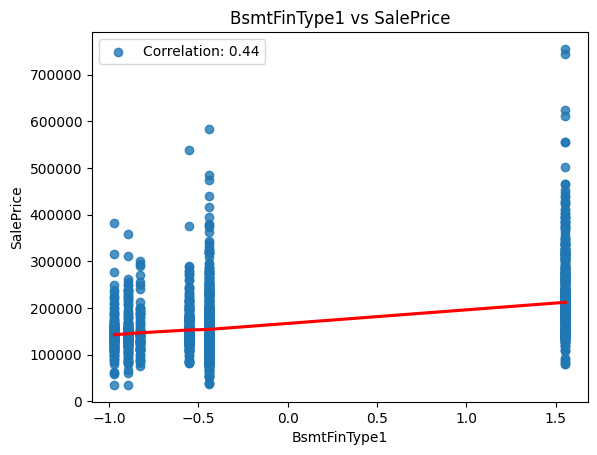

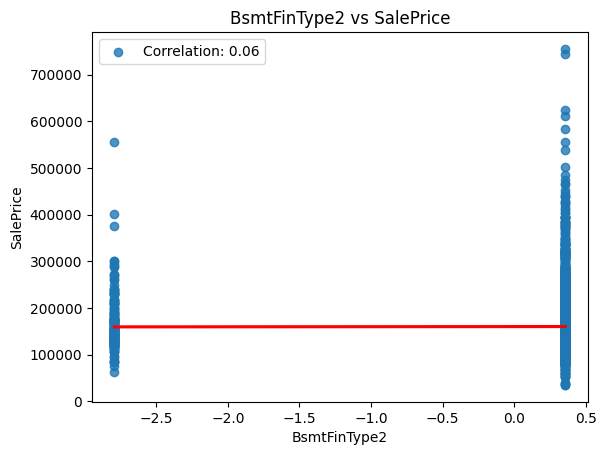

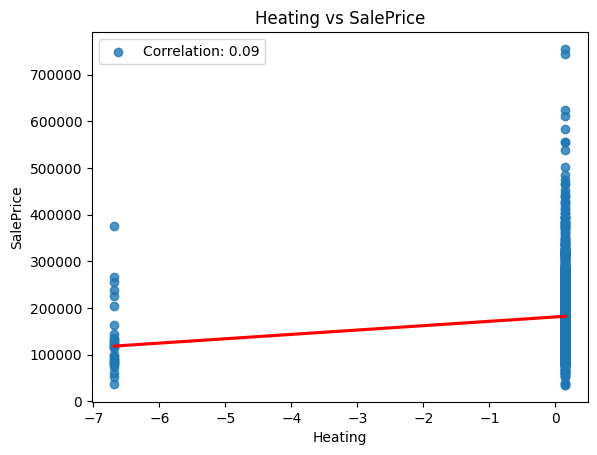

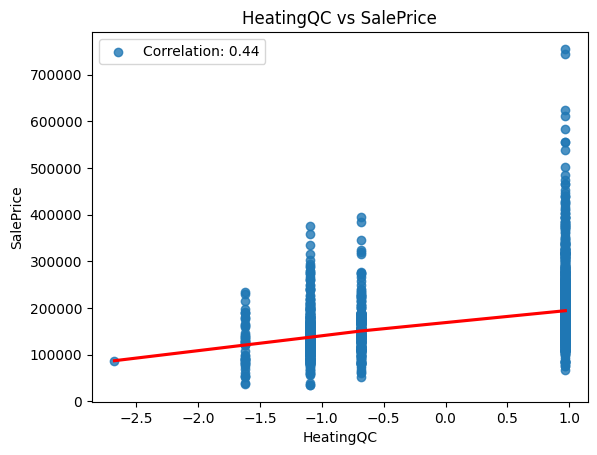

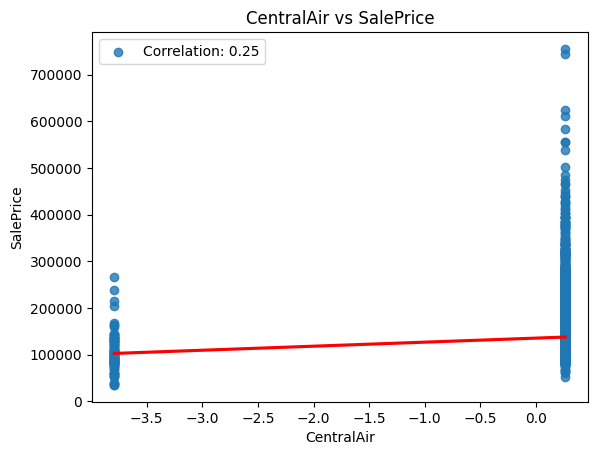

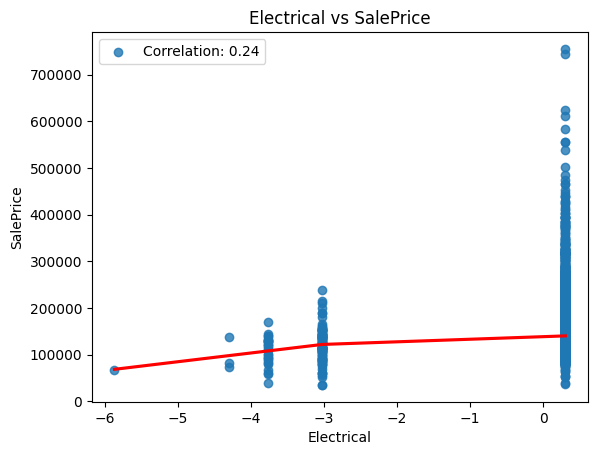

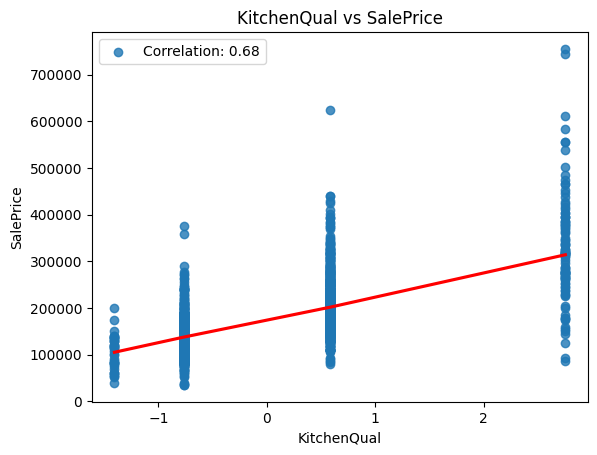

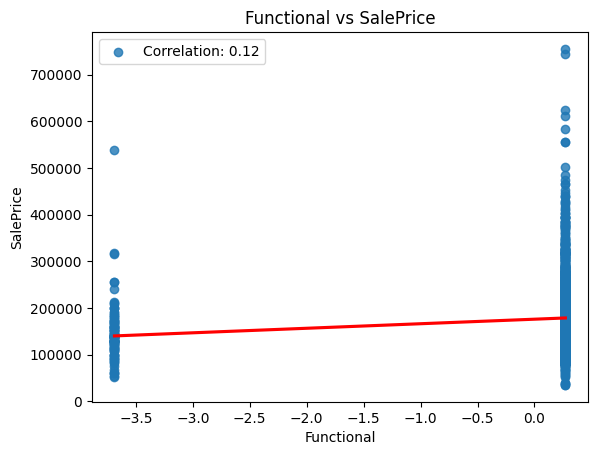

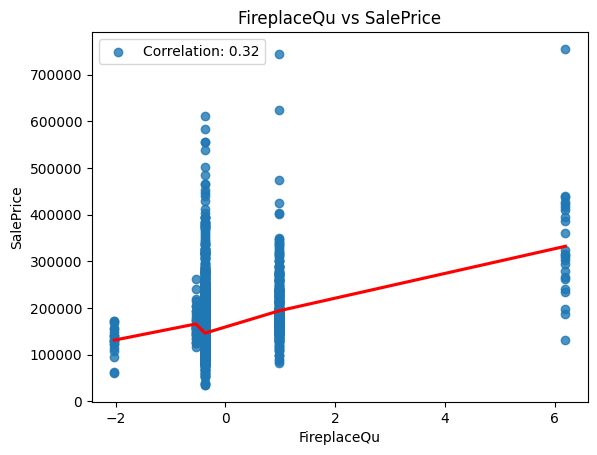

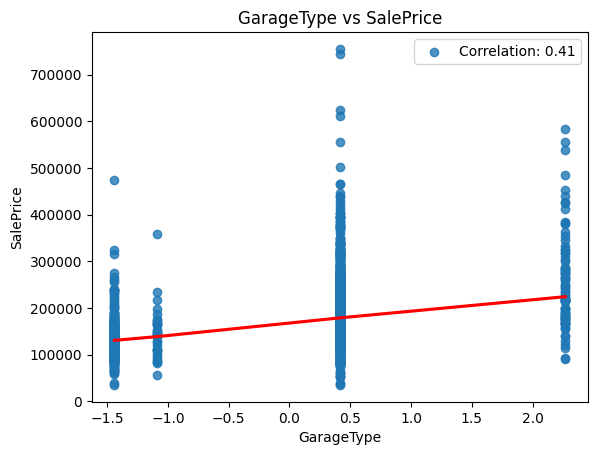

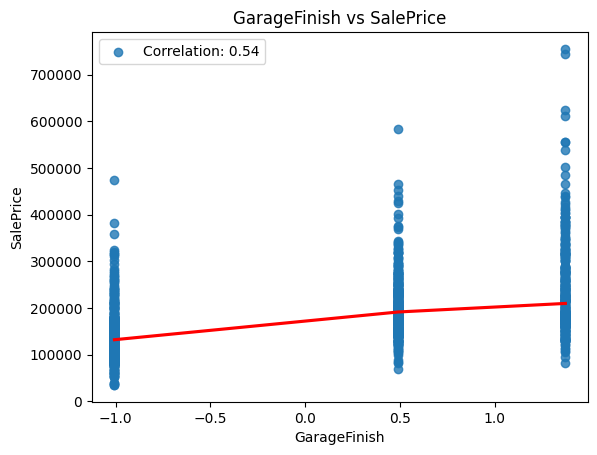

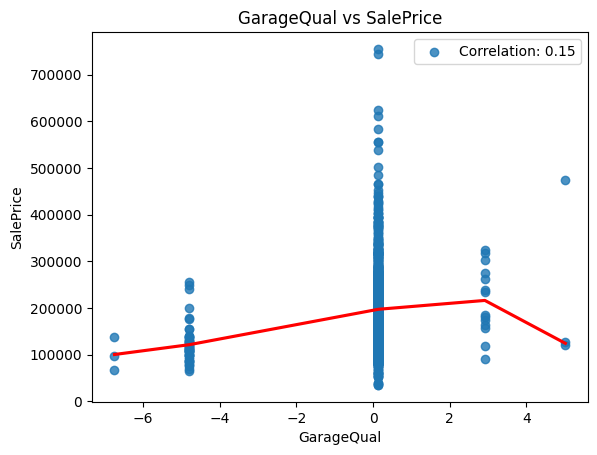

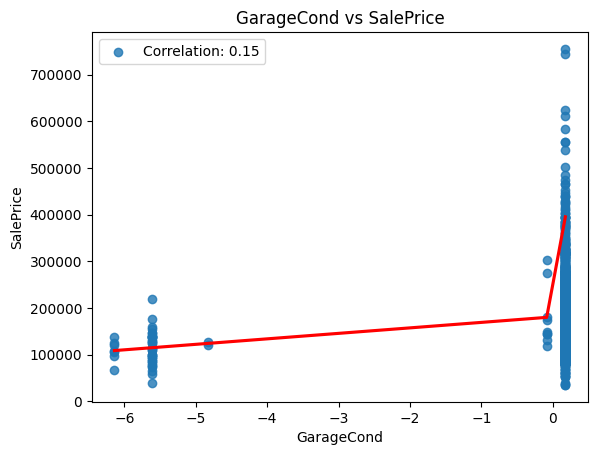

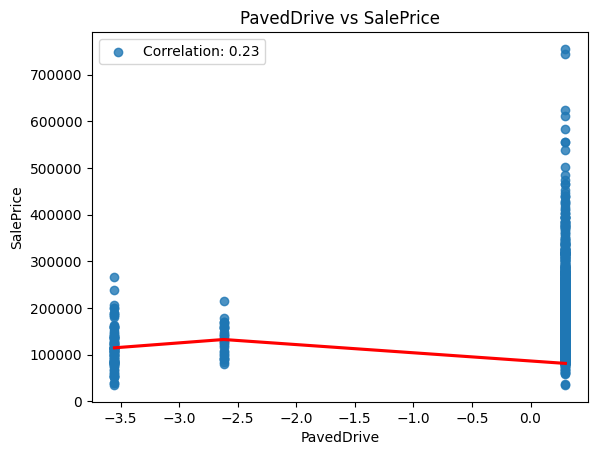

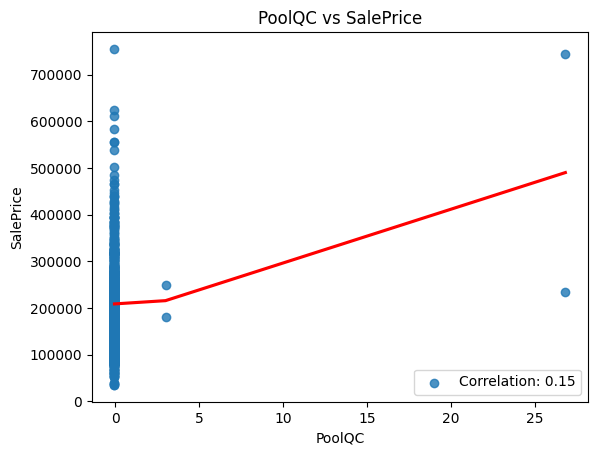

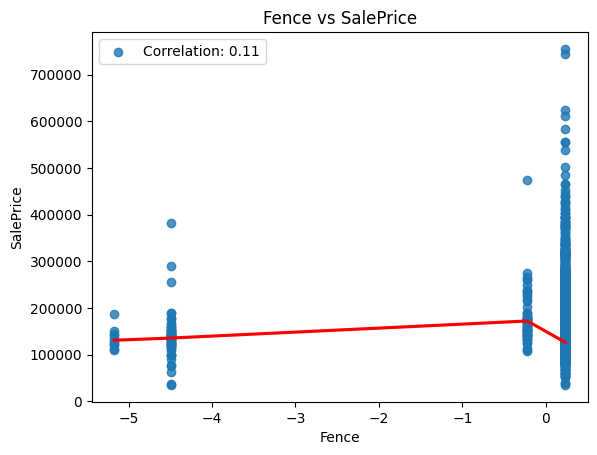

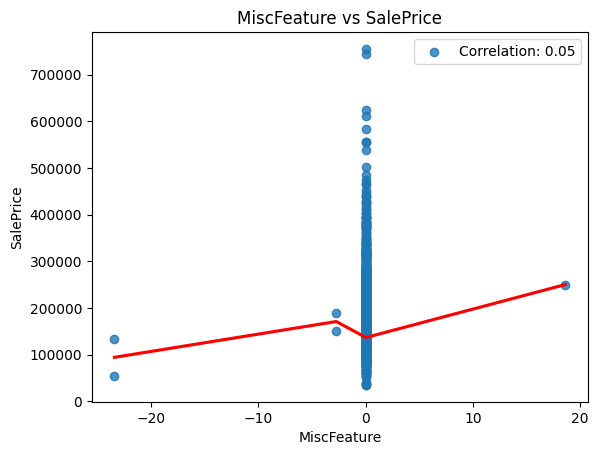

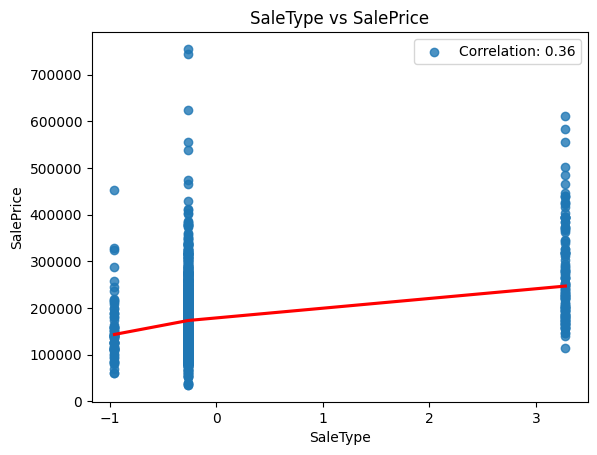

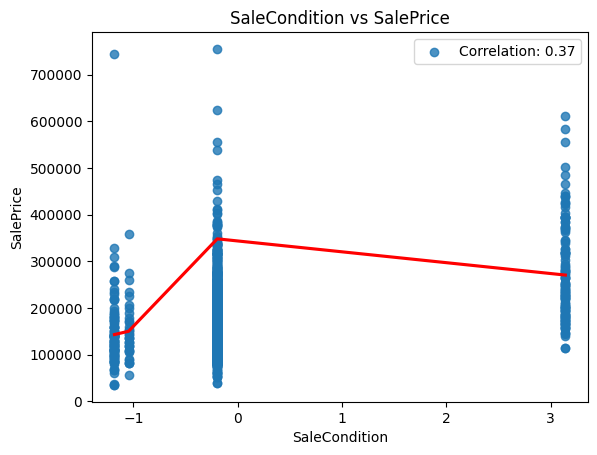

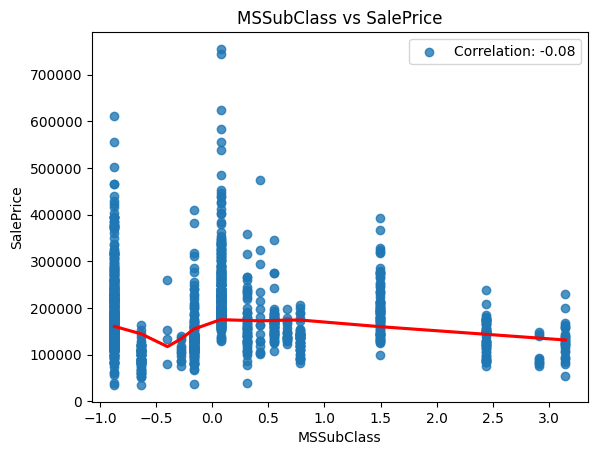

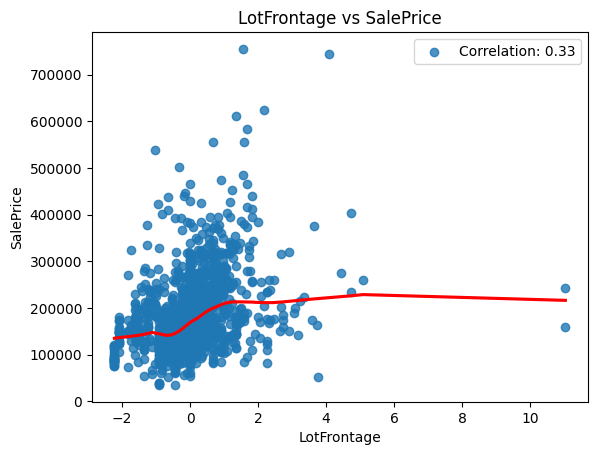

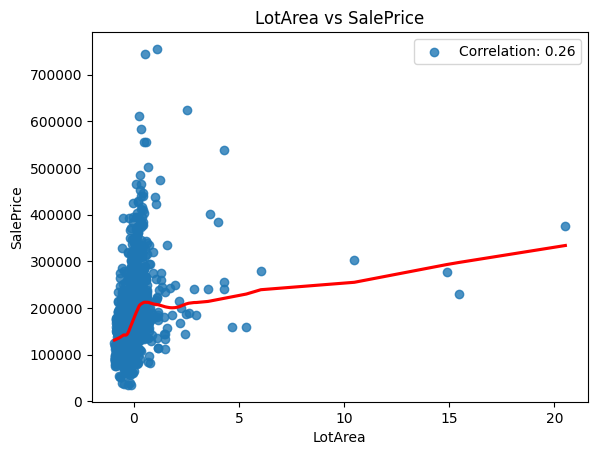

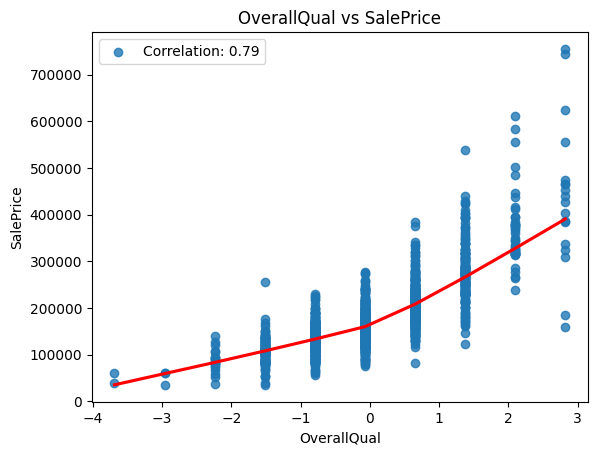

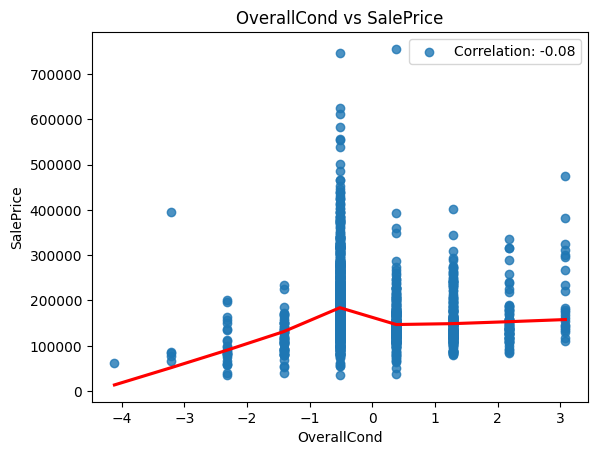

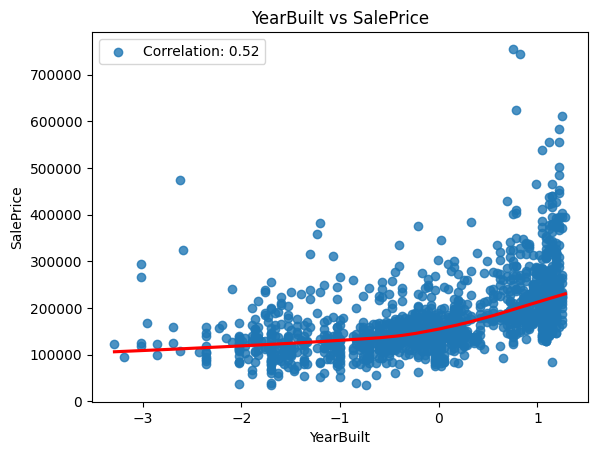

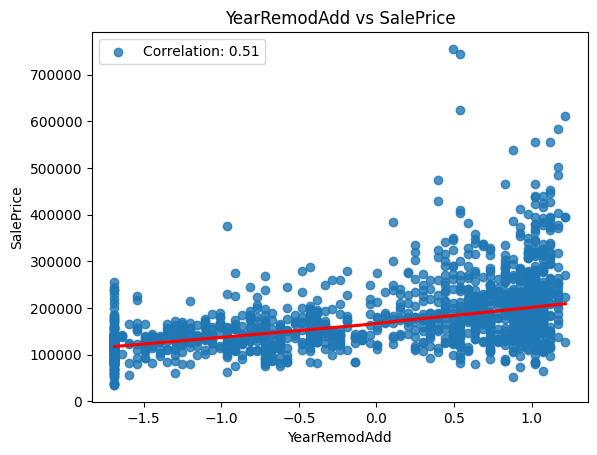

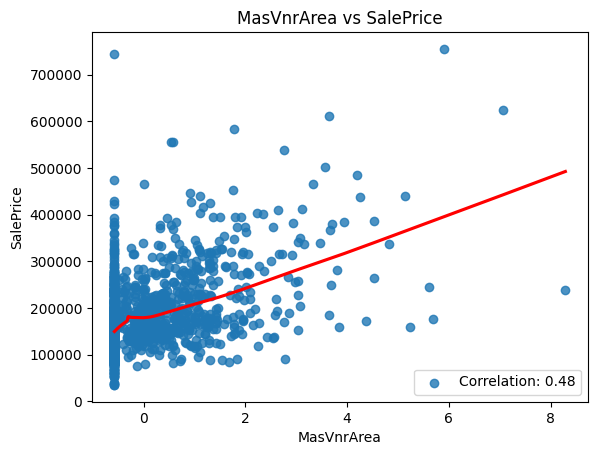

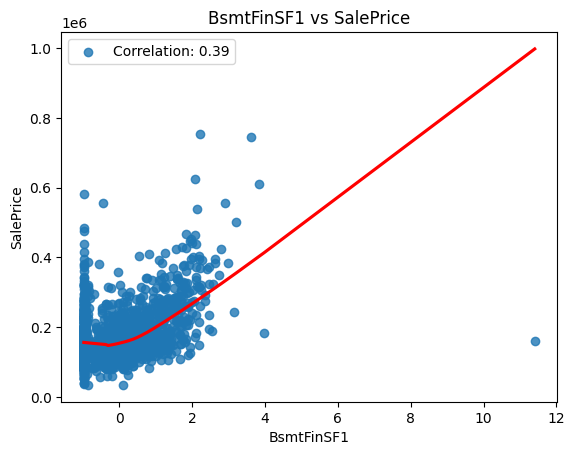

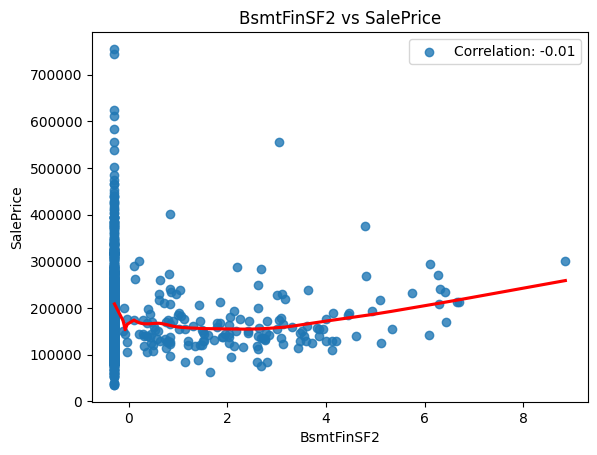

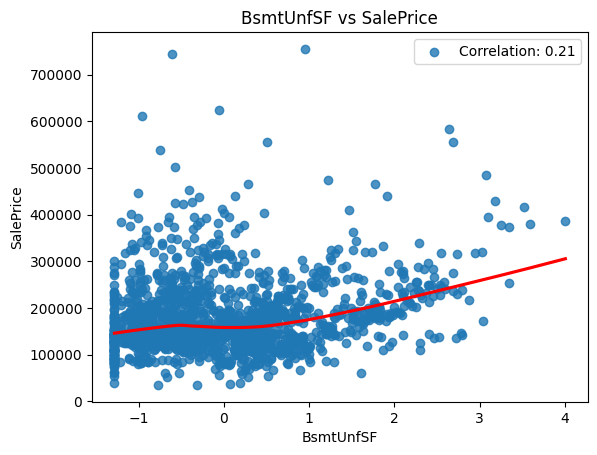

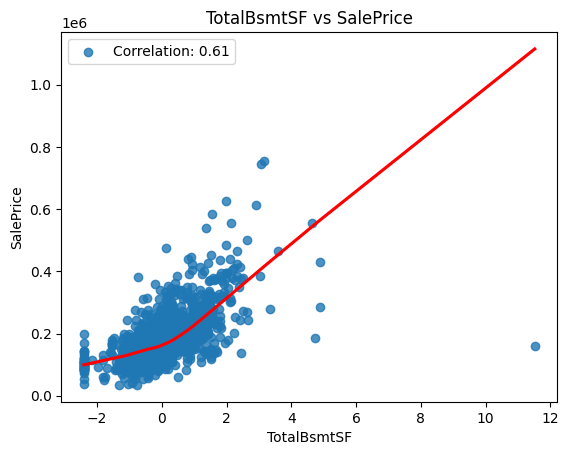

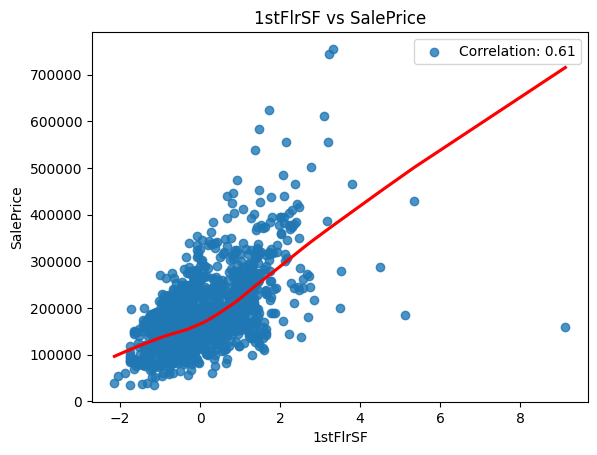

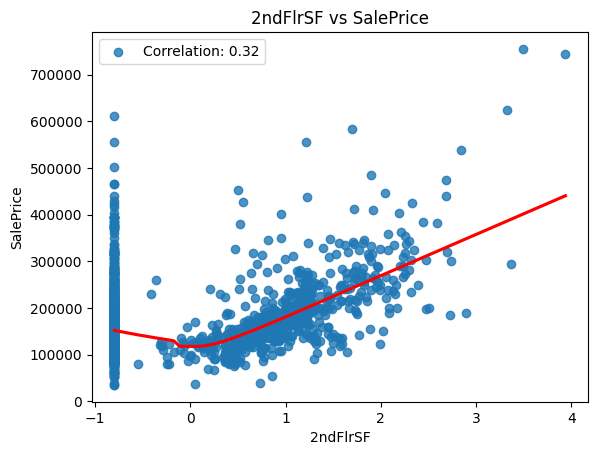

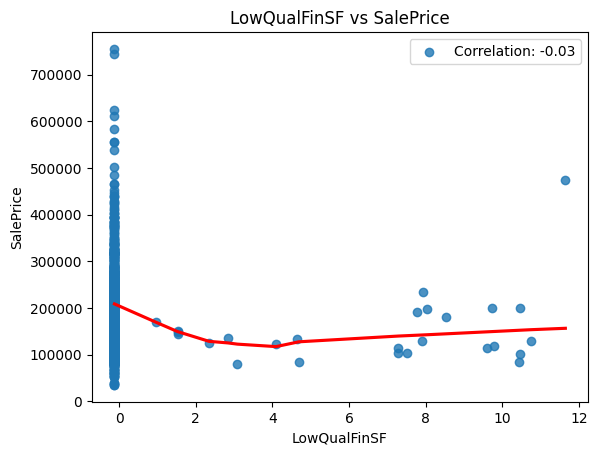

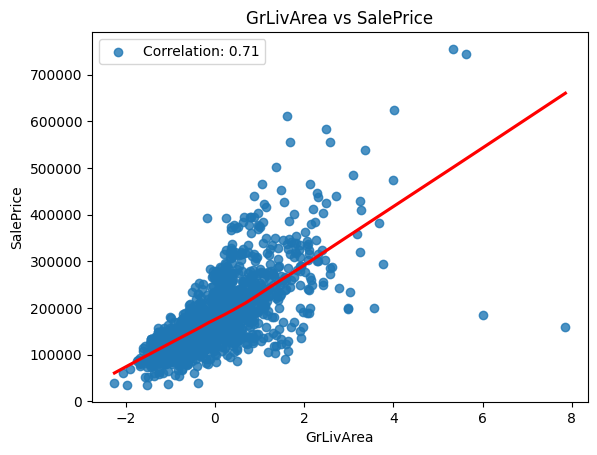

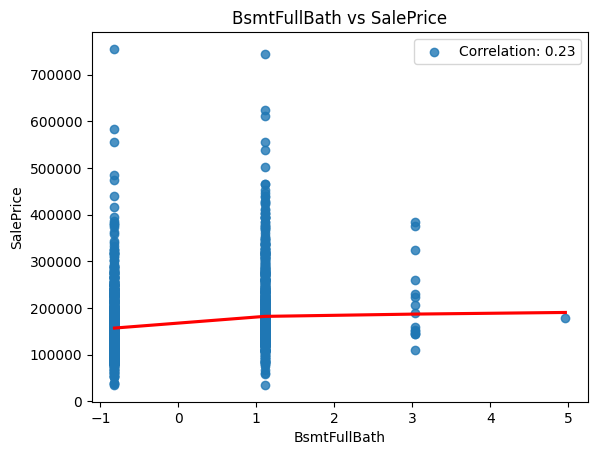

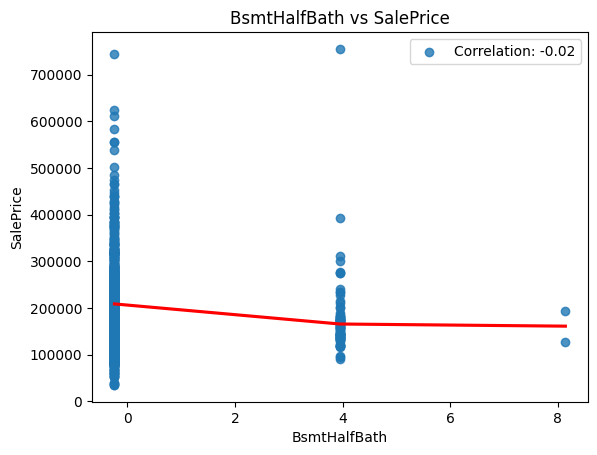

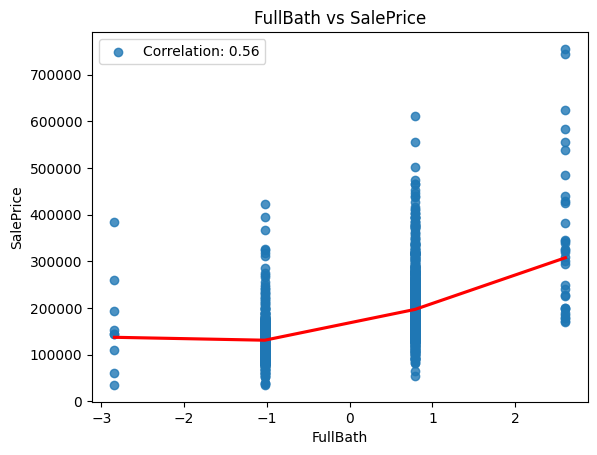

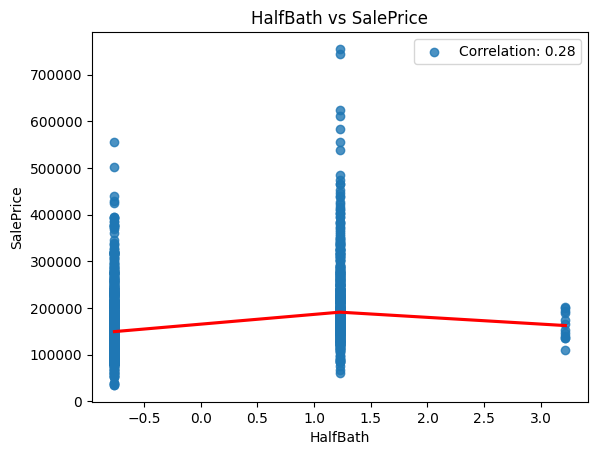

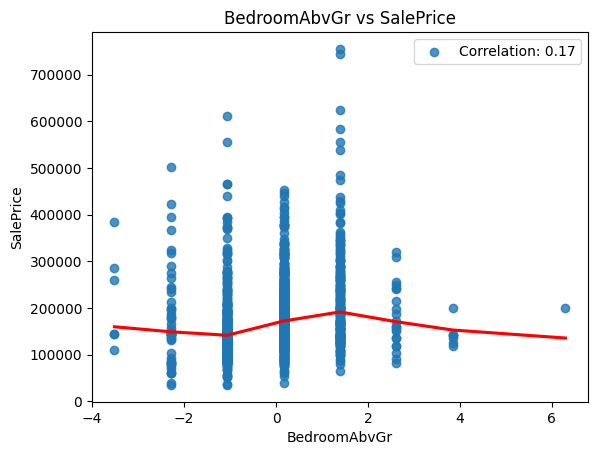

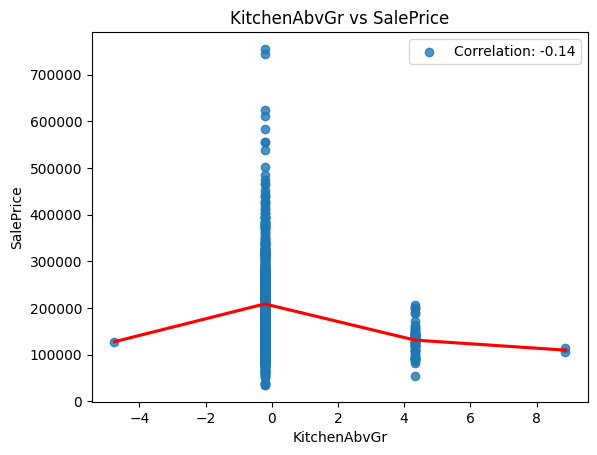

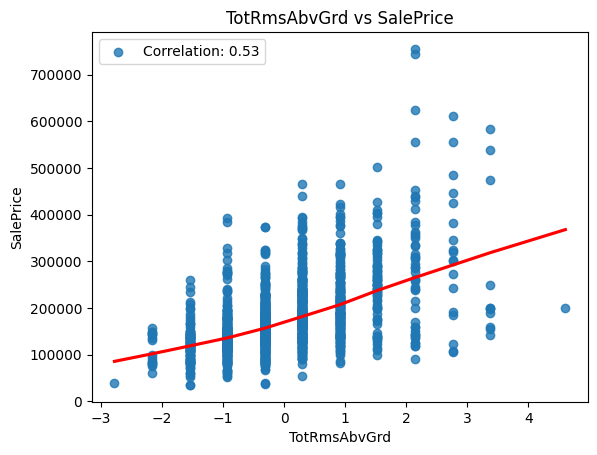

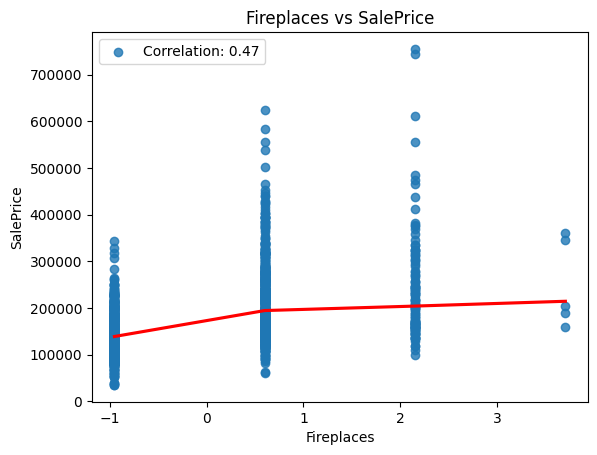

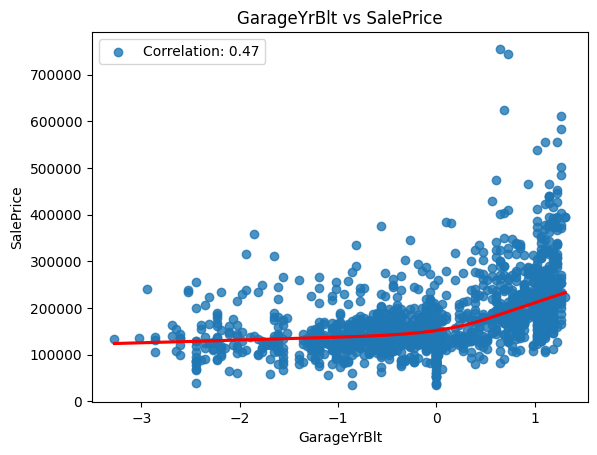

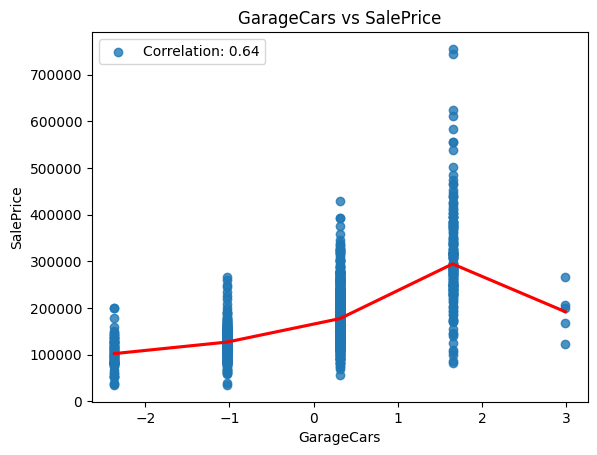

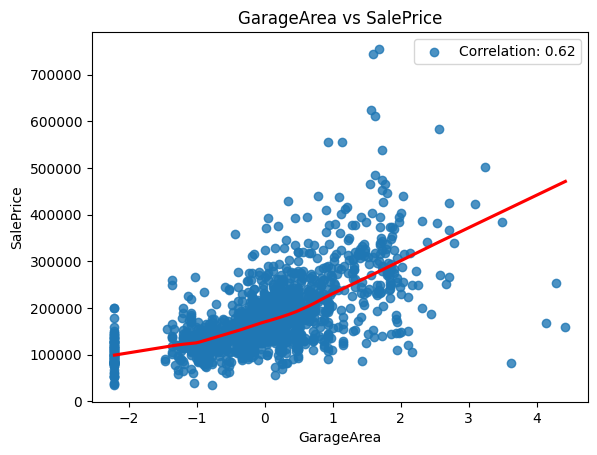

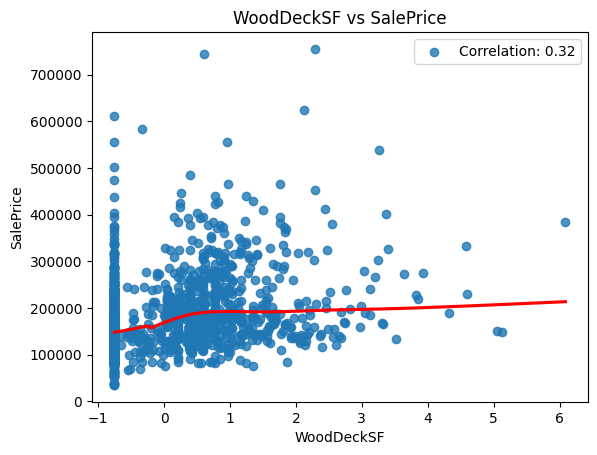

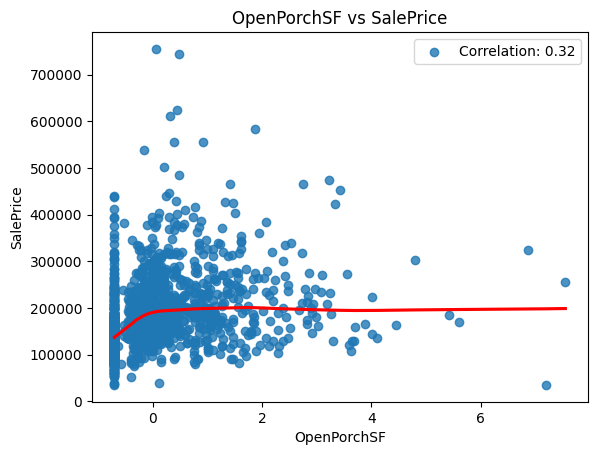

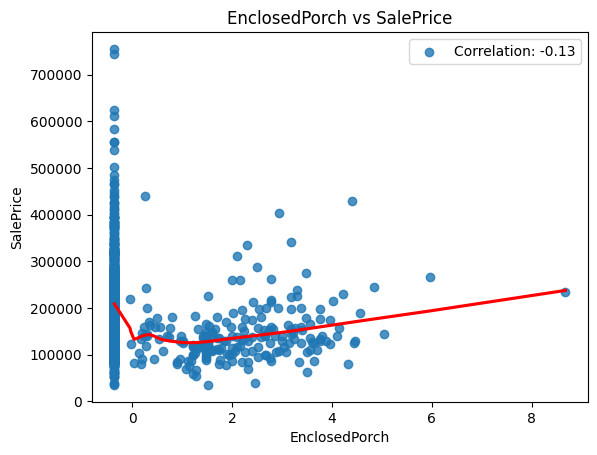

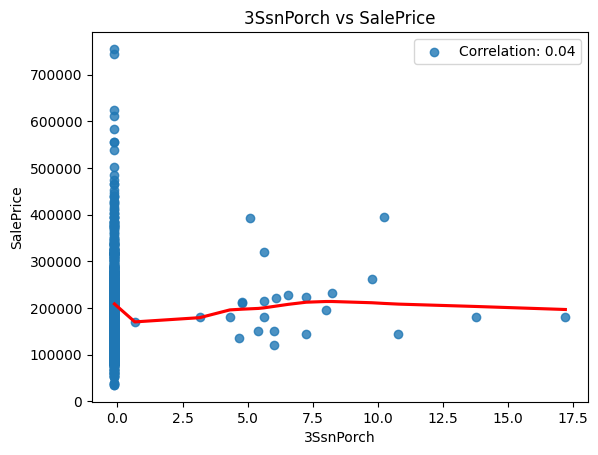

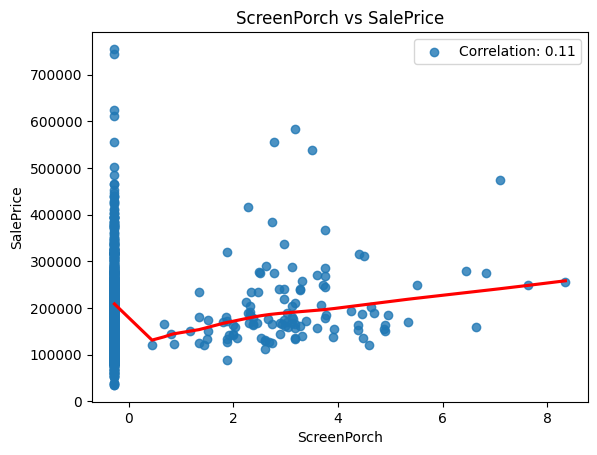

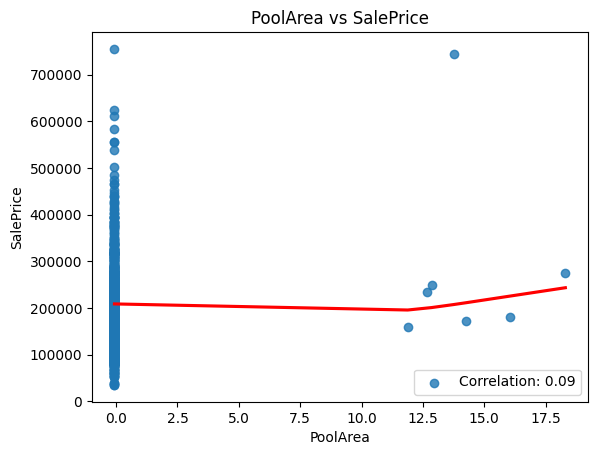

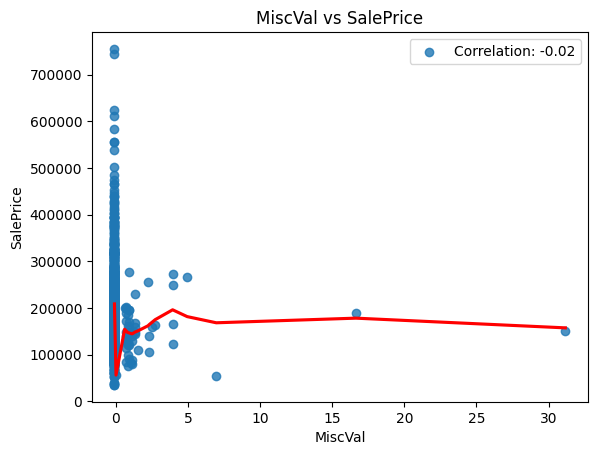

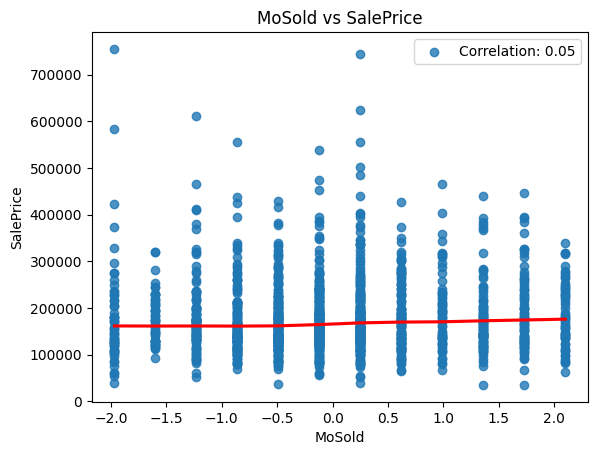

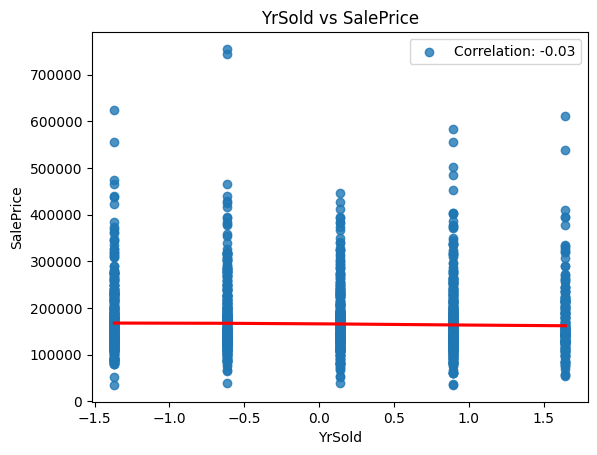

In [54]:
plot_numerical_variables(df_train, target)

# Featuren selection

In [62]:
corr_filter = CorrelationFilter(threshold = 0.1)
corr_filter.fit(X_train_t, y_train)

X_train_f = corr_filter.transform(X_train_t)
X_test_f = corr_filter.transform(X_test_t)

# Feature engineering

## Polynomial transformer

Features included togheter will add interactions between them. If this is not desired, use the poly pipe instead.

In [129]:
quadratic_cols = []

cubic_cols = []

quartic_cols = []

quintic_cols = []

In [130]:
quadratic_transformer = PolynomialFeatures(2, include_bias = False)

cubic_transformer = PolynomialFeatures(3, include_bias = False)

quartic_transformer = PolynomialFeatures(4, include_bias = False)

quintic_transformer = PolynomialFeatures(5, include_bias = False)

poly_group_pipe = ColumnTransformer(
    (
        ("quadratic", quadratic_transformer, quadratic_cols),
        ("cubic", cubic_transformer, cubic_cols),
        ("quartic", quartic_transformer, quartic_cols),
        ("quintic", quintic_transformer, quintic_cols),
    ),
    verbose_feature_names_out=False,
    remainder = "passtrough"
)

In [ ]:
poly_pipe = ColumnTransformer(
    (
        ("first_feature", PolynomialFeatures(degree = 3, include_bias = False), []),
    ),
    verbose_feature_names_out=False,
    remainder = "passtrough"
)

## Splines

Add spesific features and specify degree and n_knots for that particular feature. 

In [ ]:
spline_pipe = ColumnTransformer(
    (
        ("first_feature", SplineTransformer(n_knots = 5, degree = 3, include_bias = False), []),
    ),
    verbose_feature_names_out=False,
    remainder = "passtrough"
)

# Modeling